In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
from sklearn.preprocessing import OneHotEncoder, StandardScaler # type: ignore
from sklearn.compose import ColumnTransformer # type: ignore
from sklearn.pipeline import Pipeline, make_pipeline # type: ignore
from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, KFold # type: ignore
from joblib import dump, load # type: ignore
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay # type: ignore
from sklearn.decomposition import PCA # type: ignore
from skopt import BayesSearchCV # type: ignore
from sklearn.base import BaseEstimator, ClassifierMixin # type: ignore
from imblearn.over_sampling import RandomOverSampler, SMOTE # type: ignore
from sklearn.linear_model import SGDClassifier,  LogisticRegression # type: ignore
from sklearn.svm import LinearSVC, SVC # type: ignore
from sklearn.neighbors import KNeighborsClassifier # type: ignore
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier # type: ignore
from scipy.stats import uniform, randint # type: ignore
import shap # type: ignore
shap.initjs()
seed = 42

# 1. Descriptive Analytics

In [2]:
train_data_raw = pd.read_csv('data/train.csv')
train_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
train_data_raw.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [5]:
def wrangle(path = 'data/train.csv'):
    df = pd.read_csv(path)
    df.drop(columns = ['PassengerId', 'Name', 'Ticket'], inplace=True) # Remove non-meaningful columns
    df.drop(columns = ['Cabin'], inplace=True) # Remove too many nan-value columns
    df['Pclass'] = df['Pclass'].astype(str) # Plcass seems similar to categories 
    for column in df.columns:
        if df[column].dtype == 'int64':
            df[column] = df[column].astype(float)
    cat_features = df.drop(columns = 'Survived').select_dtypes(include = 'object').columns.tolist()
    num_features = df.drop(columns = 'Survived').select_dtypes(include = 'float').columns.tolist()
    for feature in cat_features: # Fill nan-values of num features by using median
        df[feature].fillna(value ='Others', inplace = True)
    for feature in num_features: # Fill nan-values of cat features by using 'others'
        df[feature].fillna(value = df[feature].median(), inplace = True)
    return df

In [6]:
train_data = wrangle(path = 'data/train.csv')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    float64
 5   Parch     891 non-null    float64
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(5), object(3)
memory usage: 55.8+ KB


The survival rate is 38.4%
The distribution of the target variable is not balanced and bias to the negative class


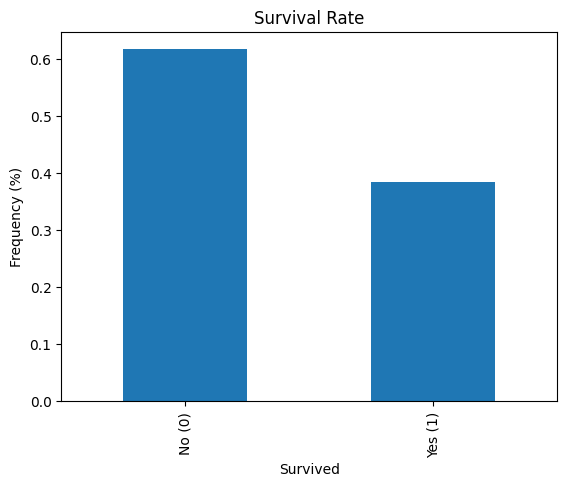

In [6]:
survival_rate = train_data.Survived.value_counts(normalize = True)
survival_rate.plot(kind='bar')
plt.xlabel('Survived')
plt.ylabel('Frequency (%)')
plt.xticks([0, 1], ['No (0)', 'Yes (1)'])
plt.title('Survival Rate');
print(f'The survival rate is {100 * survival_rate[1].round(3)}%')
print('The distribution of the target variable is not balanced and bias to the negative class')


Class 1 tens to have a higher survival rate than the other two classes
Class 3 has the lowest survival rate



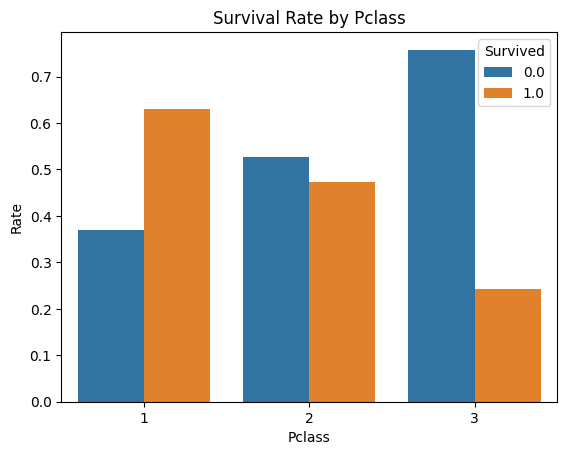

In [7]:
Pclass_group = train_data.groupby('Pclass').Survived.value_counts(normalize=True).to_frame().reset_index()
Pclass_group
sns.barplot(Pclass_group, x = 'Pclass', y = 'proportion', hue = 'Survived')
plt.xlabel('Pclass')
plt.ylabel('Rate');
plt.title('Survival Rate by Pclass')
conlusion = """
Class 1 tens to have a higher survival rate than the other two classes
Class 3 has the lowest survival rate
"""
print(conlusion)


Female tends to have a higher survival rate



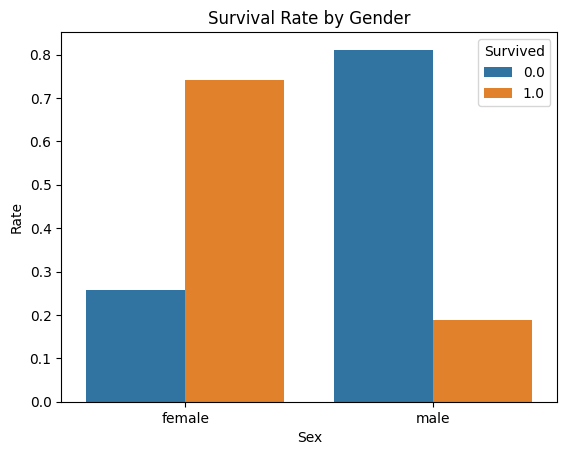

In [8]:
Sex_group = train_data.groupby('Sex').Survived.value_counts(normalize=True).to_frame().reset_index()
Sex_group
sns.barplot(Sex_group, x = 'Sex', y = 'proportion', hue = 'Survived')
plt.ylabel('Rate')
plt.title('Survival Rate by Gender');
conlusion = """
Female tends to have a higher survival rate
"""
print(conlusion)


Distribution of age is similar between the two classes



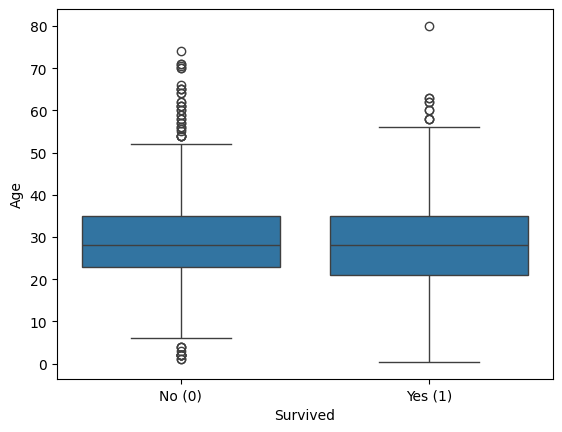

In [9]:
sns.boxplot(data = train_data, y = 'Age' , x = 'Survived')
train_data.groupby('Survived').Age.describe()
plt.xticks([0, 1], ['No (0)', 'Yes (1)']);
conlusion = """
Distribution of age is similar between the two classes
"""
print(conlusion)


Have 0 or 1 siblings / spouses tend to have a higher survival rate
Have more than 1 siblings / spouses tend to have a lower survival rate



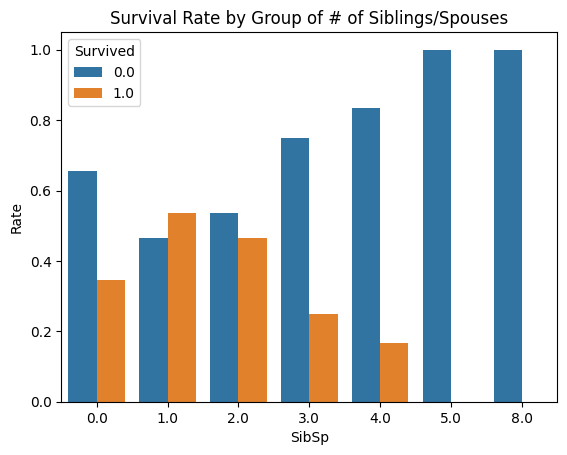

In [10]:
Sibsp_group = train_data.groupby('SibSp').Survived.value_counts(normalize = True).to_frame().reset_index()
sns.barplot(Sibsp_group, x = 'SibSp', y = 'proportion', hue = 'Survived')
plt.ylabel('Rate')
plt.title('Survival Rate by Group of # of Siblings/Spouses');
conlusion = """
Have 0 or 1 siblings / spouses tend to have a higher survival rate
Have more than 1 siblings / spouses tend to have a lower survival rate
"""
print(conlusion)


Have 0 ~ 4 Parents/Children tend to have a higher survival rate
Have more than 4 Parents/Children tend to have a lower survival rate



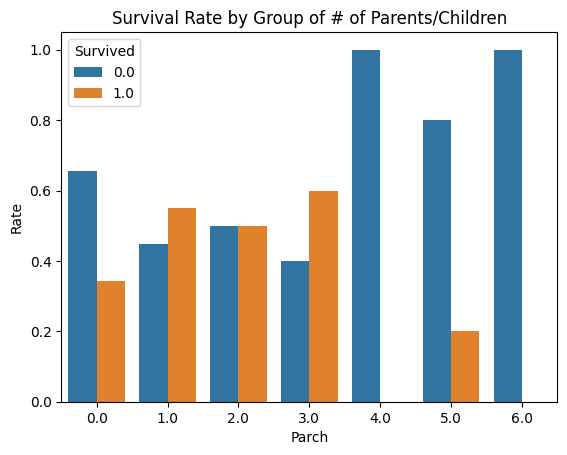

In [11]:
Parch_group = train_data.groupby('Parch').Survived.value_counts(normalize = True).to_frame().reset_index()
sns.barplot(Parch_group , x = 'Parch', y = 'proportion', hue = 'Survived')
plt.ylabel('Rate')
plt.title('Survival Rate by Group of # of Parents/Children');
conlusion = """
Have 0 ~ 4 Parents/Children tend to have a higher survival rate
Have more than 4 Parents/Children tend to have a lower survival rate
"""
print(conlusion)

          count       mean        std  min      25%   50%   75%       max
Survived                                                                 
0.0       549.0  22.117887  31.388207  0.0   7.8542  10.5  26.0  263.0000
1.0       342.0  48.395408  66.596998  0.0  12.4750  26.0  57.0  512.3292

Distribution of fare of 2 classes are both right-skewed
More money spent on fare tends to have a higher survival rate



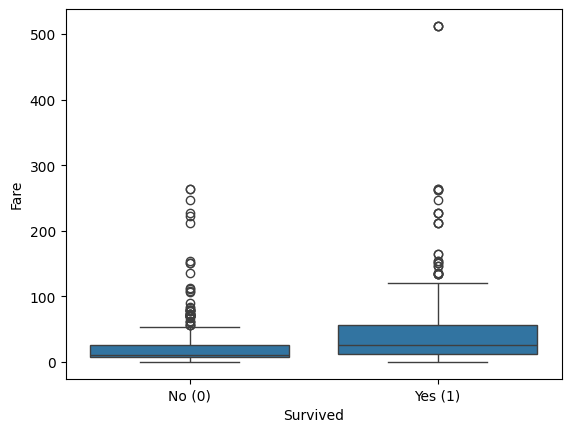

In [12]:
sns.boxplot(data = train_data, y = 'Fare' , x = 'Survived')
print(train_data.groupby('Survived').Fare.describe())
plt.xticks([0, 1], ['No (0)', 'Yes (1)']);
conlusion = """
Distribution of fare of 2 classes are both right-skewed
More money spent on fare tends to have a higher survival rate
"""
print(conlusion)


Passegners from Southampton, Queenstown and others tends to have higher



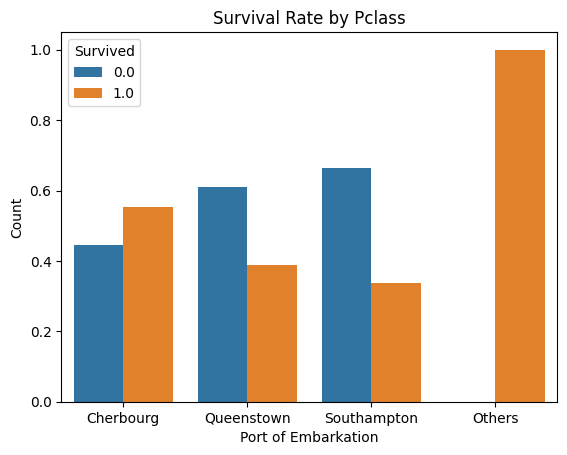

In [13]:
Embarked_group = train_data.groupby('Embarked').Survived.value_counts(normalize=True).to_frame().reset_index()
Pclass_group
sns.barplot(Embarked_group, x = 'Embarked', y = 'proportion', hue = 'Survived', order = ['C', 'Q', 'S', 'Others'])
plt.xlabel('Port of Embarkation')
plt.ylabel('Count');
plt.xticks([0, 1, 2, 3], ['Cherbourg', 'Queenstown', 'Southampton', 'Others']);
plt.title('Survival Rate by Pclass')
conlusion = """
Passegners from Southampton, Queenstown and others tends to have higher
"""
print(conlusion)

# 2. Diagnostic Analytics


Numeric features seems have no relation between each others,
This is a good signal for making a prediction model,
However, the correlation between the target variable and each input features are not clear, which means that making a good model might not be easy



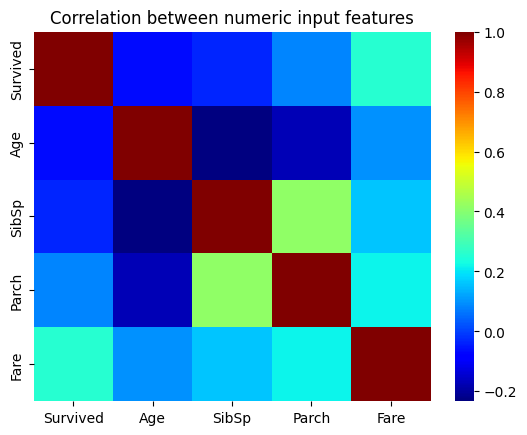

In [14]:
corr = train_data.select_dtypes(float).corr()
sns.heatmap(corr, cmap = 'jet')
plt.title('Correlation between numeric input features')
conclusion = """
Numeric features seems have no relation between each others,
This is a good signal for making a prediction model,
However, the correlation between the target variable and each input features are not clear, which means that making a good model might not be easy
"""
print(conclusion)


The pairplot confirms that there is no relation between features in both two classes of survival
The clusters are visile in the plot of SibSp vs Parch, 
All features are perfectly independent



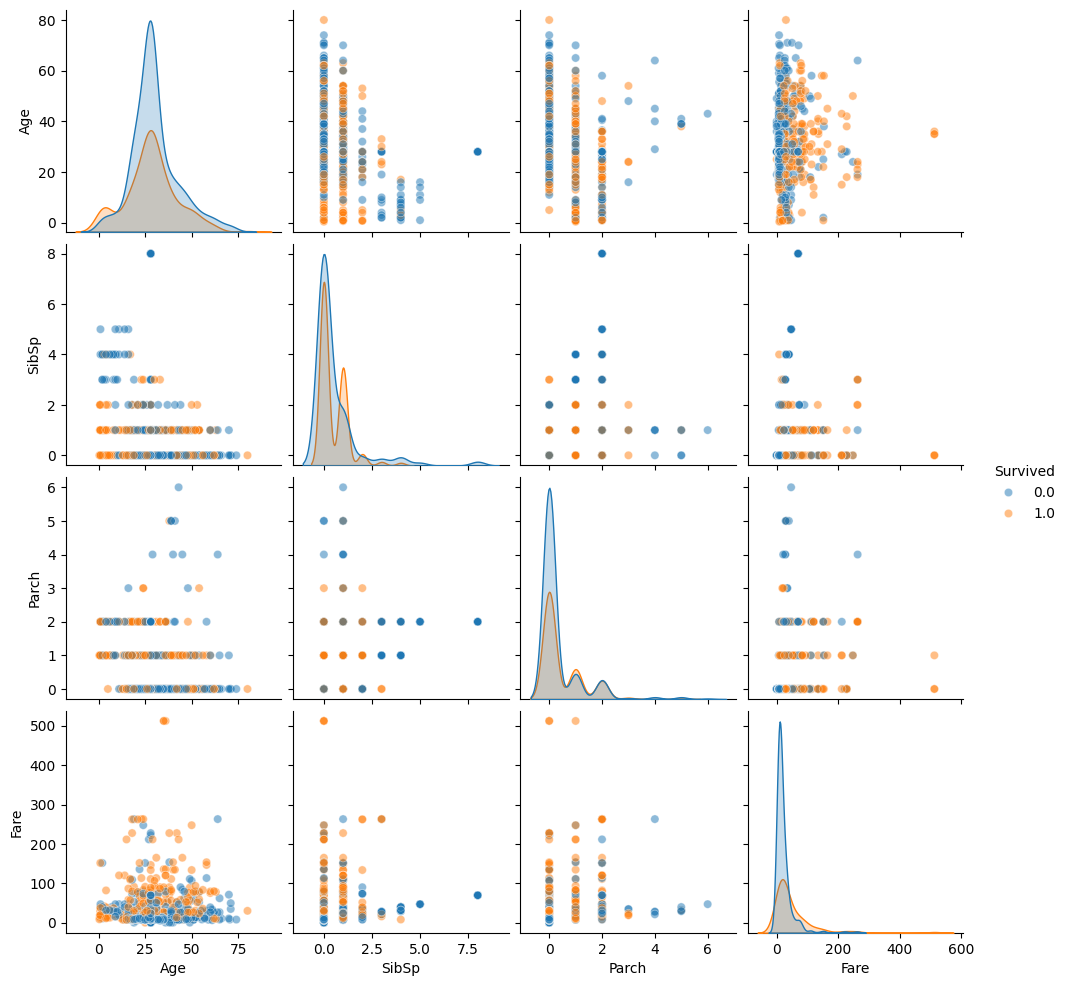

In [15]:
sns.pairplot(train_data, hue = 'Survived', plot_kws = {'alpha': 0.5});
conclusion = """
The pairplot confirms that there is no relation between features in both two classes of survival
The clusters are visile in the plot of SibSp vs Parch, 
All features are perfectly independent
"""
print(conclusion)


Distributions of all features w.r.t classes of Embarked are pretty much similar



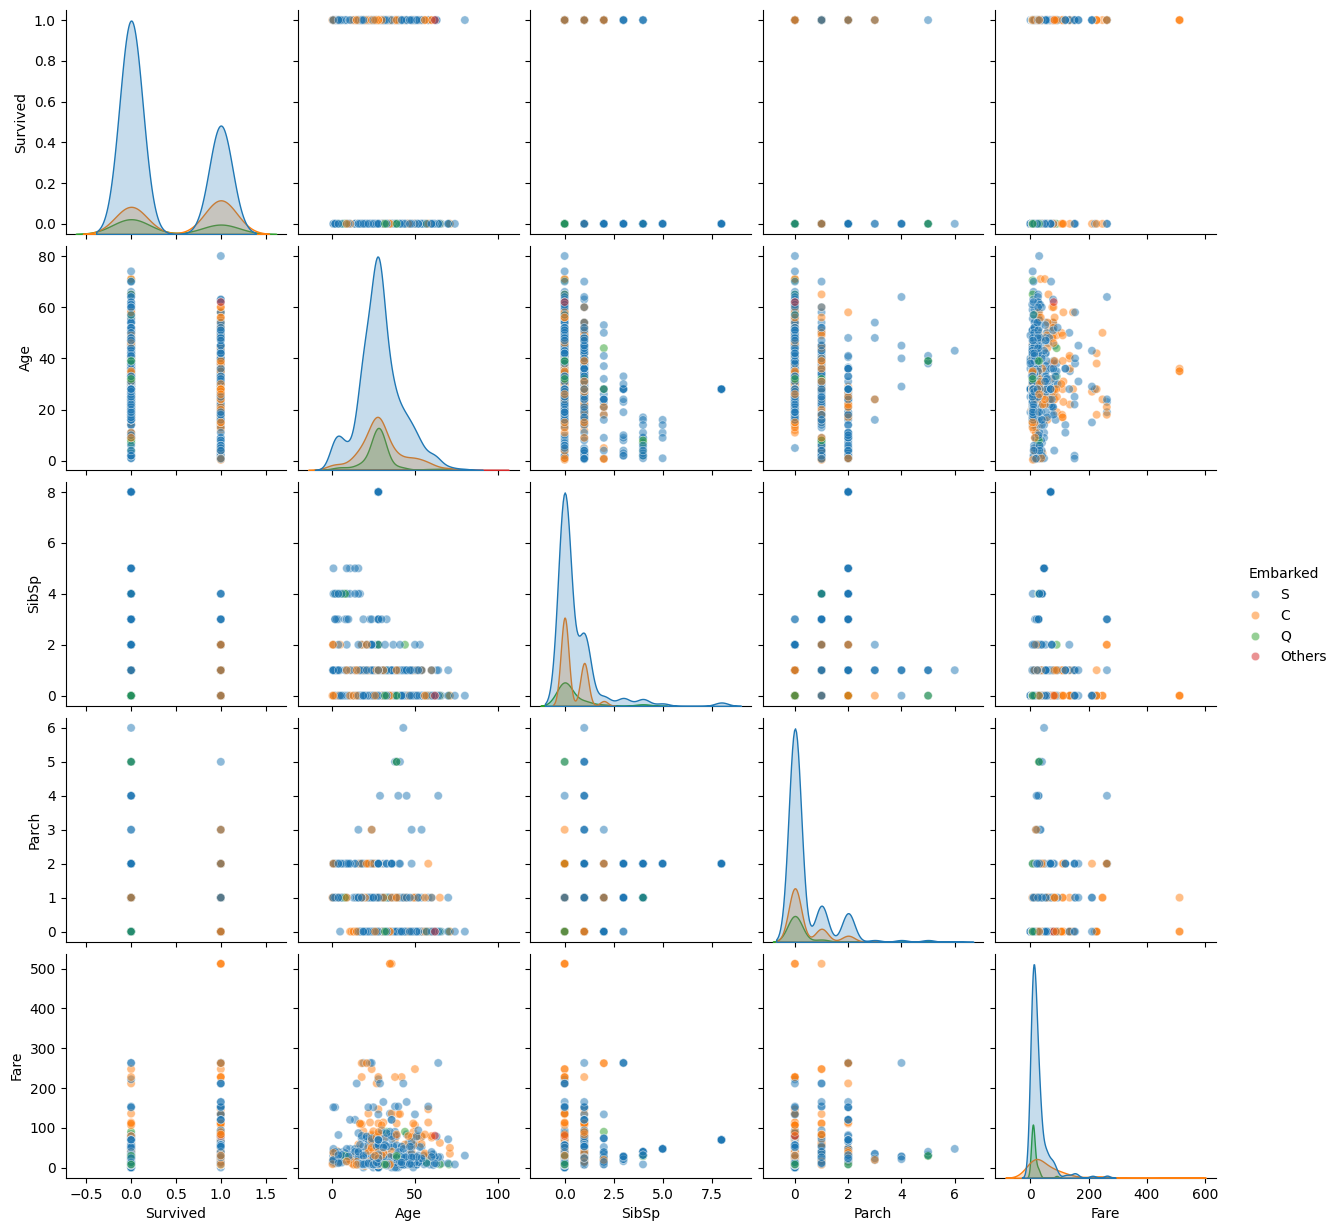

In [16]:
sns.pairplot(train_data, hue = 'Embarked', plot_kws = {'alpha': 0.5});
conclusion = """
Distributions of all features w.r.t classes of Embarked are pretty much similar
"""
print(conclusion)


There is no clear patterns between features and classes of Pclass



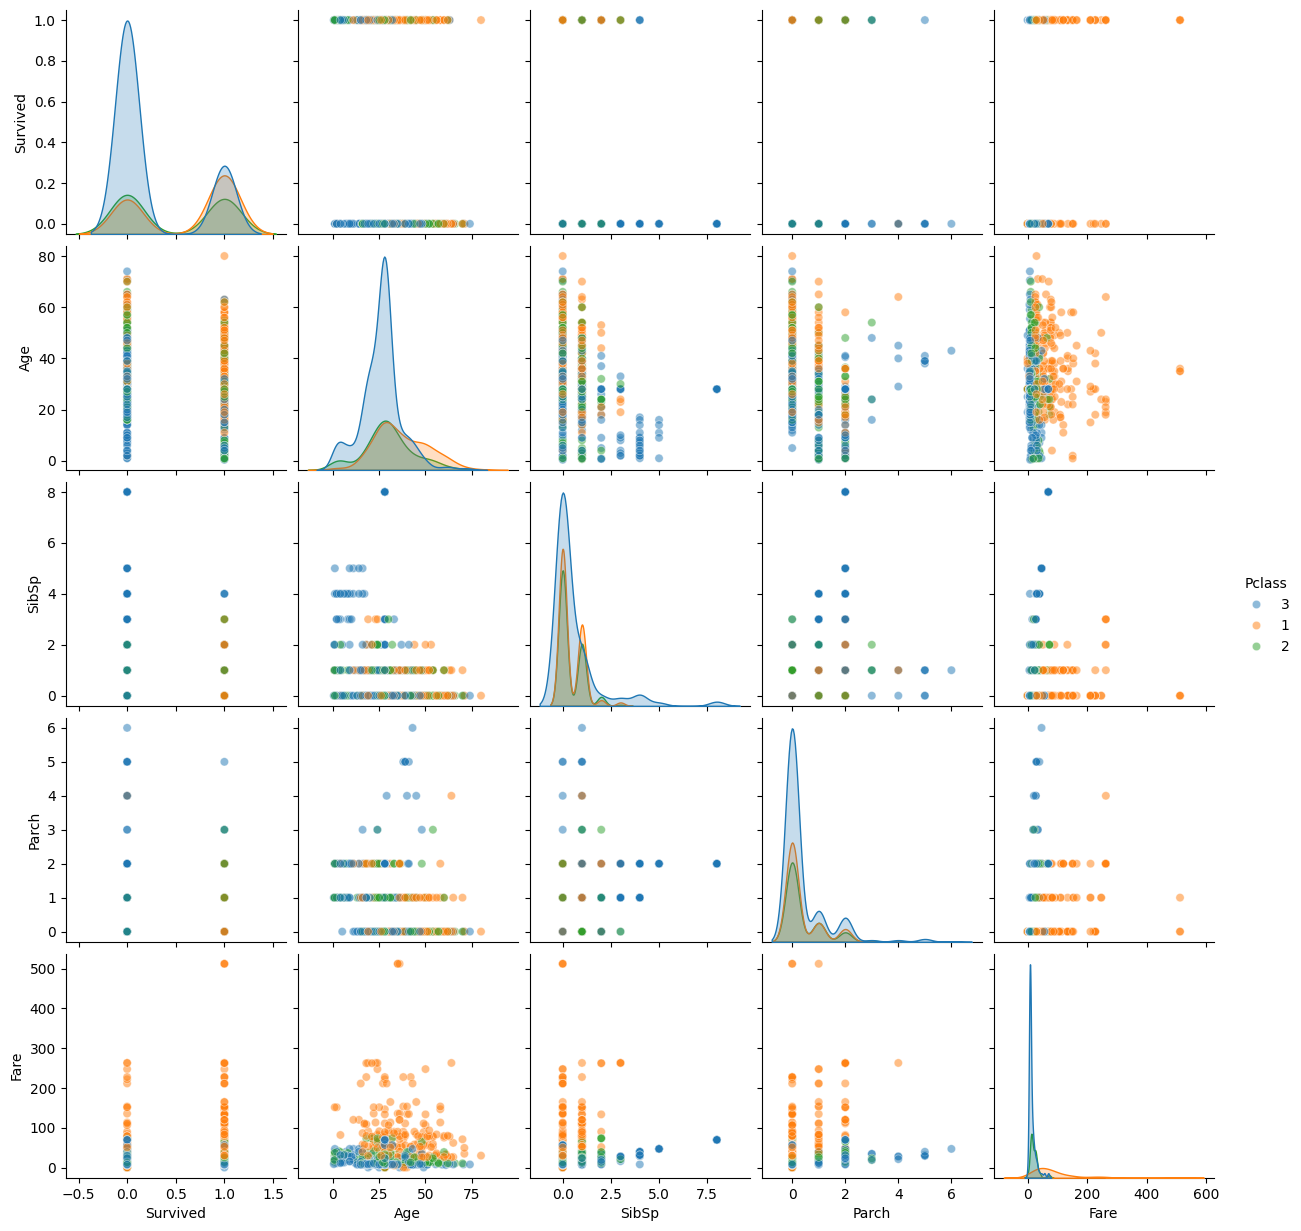

In [17]:
sns.pairplot(train_data, hue = 'Pclass', plot_kws = {'alpha': 0.5});
conclusion = """
There is no clear patterns between features and classes of Pclass
"""
print(conclusion)


No patterns between features and classes, no clusters



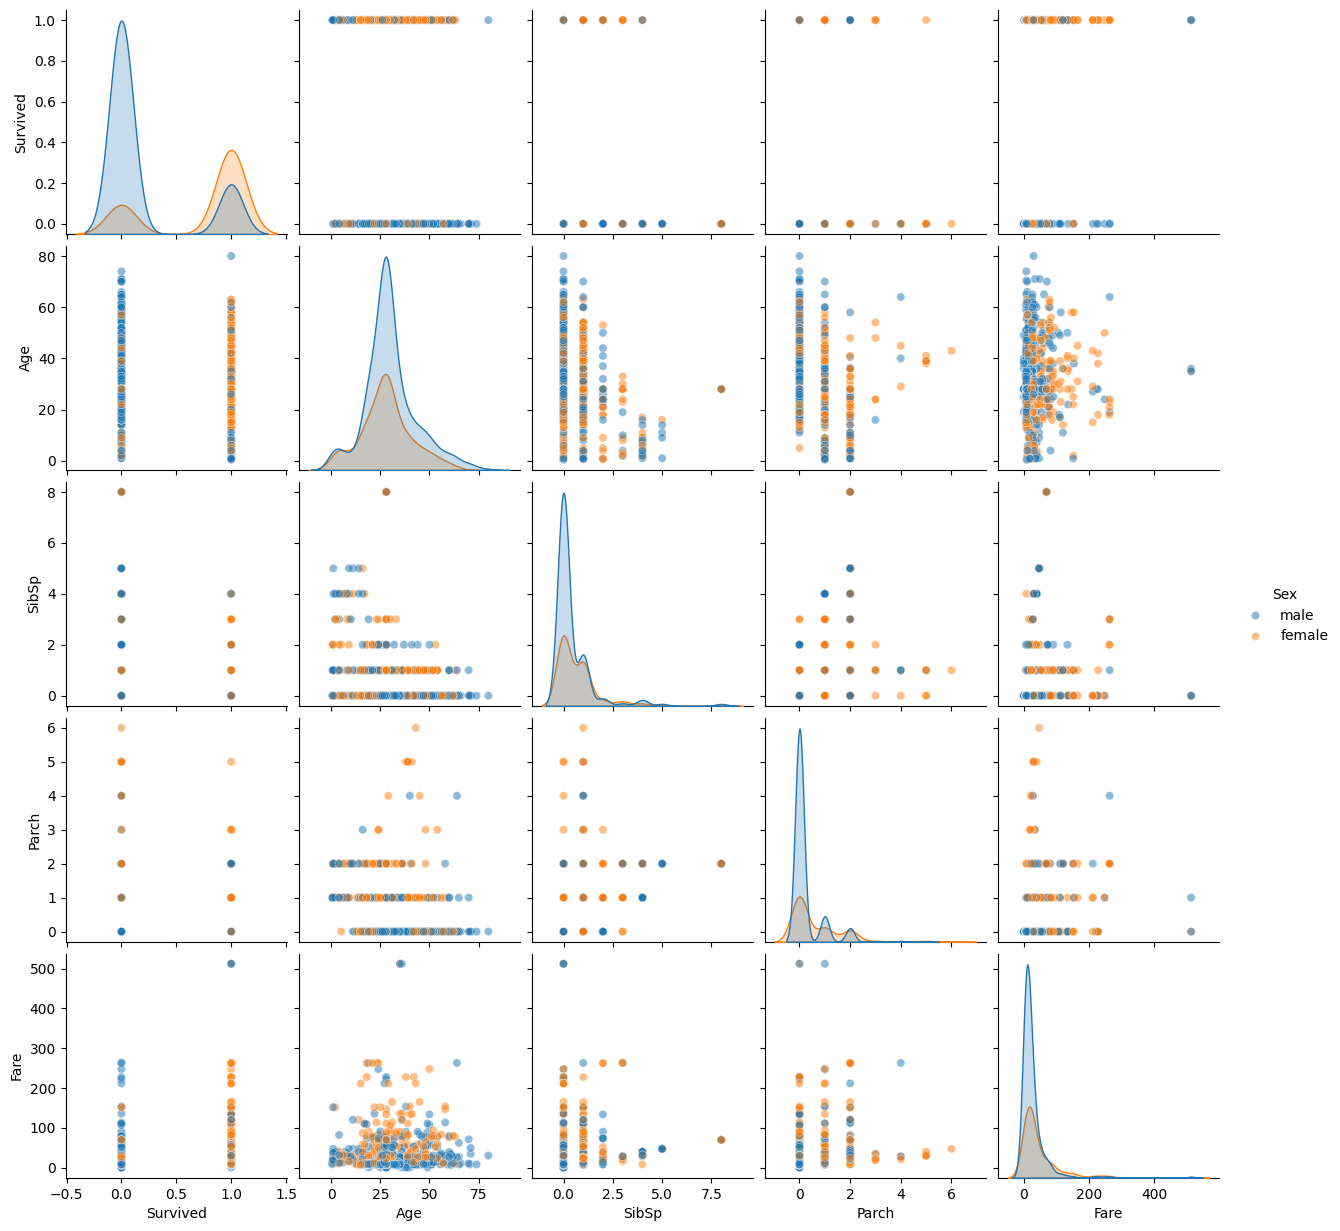

In [18]:
sns.pairplot(train_data, hue = 'Sex', plot_kws = {'alpha': 0.5});
conclusion = """
No patterns between features and classes, no clusters
"""
print(conclusion)

# 3. Predictive Analytics 


## 3.1 Search for an appropriate model

In [7]:
base_model_accuracy = train_data['Survived'].value_counts(normalize = True).max()

In [9]:
X = train_data.drop(columns = 'Survived')
y = train_data['Survived']
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1.0,0.0,7.2500,S
1,1,female,38.0,1.0,0.0,71.2833,C
2,3,female,26.0,0.0,0.0,7.9250,S
3,1,female,35.0,1.0,0.0,53.1000,S
4,3,male,35.0,0.0,0.0,8.0500,S


In [10]:
cat_features = X.select_dtypes(include = 'object').columns.tolist()
num_features = X.select_dtypes(include = 'float').columns.tolist()
column_trans = ColumnTransformer(
    [('cat', OneHotEncoder(dtype='int',  handle_unknown = 'ignore'), cat_features),
     ('num', StandardScaler(), num_features)])

- Big question: How to choose the right estimator for the problem?
- Luckily, scikit-learn users can use the `estimator selection flowchart` hint to help us choose the right estimator for the problem
- So, the four applicants for our problem:`LinearSVC`, `SGDClassifier`, `KNeighborsClassifier`, and `kernel approximation`, `SVC` and `Ensemble Classifiers`
![Hint for model selection](estimator_hint.png)

In [13]:
# The helper function helps the GridSearchCV looking at the worst case to seeking for the best model
def lower_bound(cv_results):
    """
    Calculate the lower bound within 1 standard deviation
    of the best `mean_test_scores`.

    Parameters
    ----------
    cv_results : dict of numpy(masked) ndarrays
        See attribute cv_results_ of `GridSearchCV`

    Returns
    -------
    int
        index of the max lower bound within 1.96 standard deviation of the `mean_test_score`.
    """
    lower_bound = cv_results["mean_test_score"] - 1.96 * cv_results["std_test_score"]
    best_score_idx = np.argmax(lower_bound)
    return best_score_idx

mlp = MLPClassifier(solver='adam', max_iter = 3000, random_state=42, learning_rate = 'adaptive')
mlp_params = {'mlpclassifier__hidden_layer_sizes': [(10,10), (25, 25), (50, 50), (100, 100)],
              'mlpclassifier__alpha': [0.0001, 0.001, 0.01, 0.1]}
sgdc = SGDClassifier(max_iter = 3000, random_state=42)
sgdc_params = {'sgdclassifier__alpha': [0.0001, 0.001, 0.01, 0.1]}
lsvc = LinearSVC(dual = 'auto', max_iter = 3000)
lsvc_params = {'linearsvc__C': [0.001, 0.01, 1, 10]}
svc = SVC(gamma = 'auto')
svc_params = {'svc__C': [0.001, 0.01, 1, 10],
                'svc__kernel': ['linear', 'poly', 'rbf']}
knn = KNeighborsClassifier()
knn_params = {'kneighborsclassifier__n_neighbors': [3, 5, 7, 9]}
gbc = GradientBoostingClassifier(random_state=42)
gbc_params = {'gradientboostingclassifier__n_estimators': [50, 100, 150, 200],
              'gradientboostingclassifier__max_depth': [2,5,10,15]}
lr = LogisticRegression(max_iter = 3000)
lr_params = {'logisticregression__C': [0.001, 0.01, 1, 10]}
rf = RandomForestClassifier(random_state=42)
rf_params = {'randomforestclassifier__n_estimators': [50, 100, 150, 200],
             'randomforestclassifier__max_depth': [2,5,10,15]}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = seed, stratify = y)
scoring = 'accuracy'

In [ ]:
inner_cv = KFold(n_splits=3, shuffle=True, random_state=seed)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=seed)
models = [('mlp', GridSearchCV(make_pipeline(column_trans, mlp), mlp_params, cv = inner_cv, refit = lower_bound)),
            ('sgdc', GridSearchCV(make_pipeline(column_trans, sgdc), sgdc_params, cv = inner_cv, refit = lower_bound)),
            ('lsvc', GridSearchCV(make_pipeline(column_trans, lsvc), lsvc_params, cv = inner_cv, refit = lower_bound)),
            ('svc', GridSearchCV(make_pipeline(column_trans, svc), svc_params, cv = inner_cv, refit = lower_bound)),
            ('knn', GridSearchCV(make_pipeline(column_trans, knn), knn_params, cv = inner_cv, refit = lower_bound)),
            ('gbc', GridSearchCV(make_pipeline(column_trans, gbc), gbc_params, cv = inner_cv, refit = lower_bound)),
            ('lr', GridSearchCV(make_pipeline(column_trans, lr), lr_params, cv = inner_cv, refit = lower_bound)),
            ('rf', GridSearchCV(make_pipeline(column_trans, rf), rf_params, cv = inner_cv, refit = lower_bound))
]
score_kfold = {'model' : [], 'mean_train': [], 'std_train': [], 'lower_bound_train': [], 'test': []}
for name, model in models:
    nested_cv_results = cross_val_score(model, X_train, y_train, cv=outer_cv, scoring=scoring)
    msg = "Nested CV Accuracy %s: %f (+/- %f )" % (name, nested_cv_results.mean()*100, nested_cv_results.std()*100)
    print(msg)
    model.fit(X_train, y_train)
    print('Test set accuracy: {:.2f}'.format(model.score(X_test, y_test)*100),  '%')
    score_kfold['model'].append(name)
    score_kfold['mean_train'].append(nested_cv_results.mean())
    score_kfold['std_train'].append(nested_cv_results.std())
    score_kfold['lower_bound_train'].append(nested_cv_results.mean() - 1.96*nested_cv_results.std())
    score_kfold['test'].append(model.score(X_test, y_test))

KNN is the winner


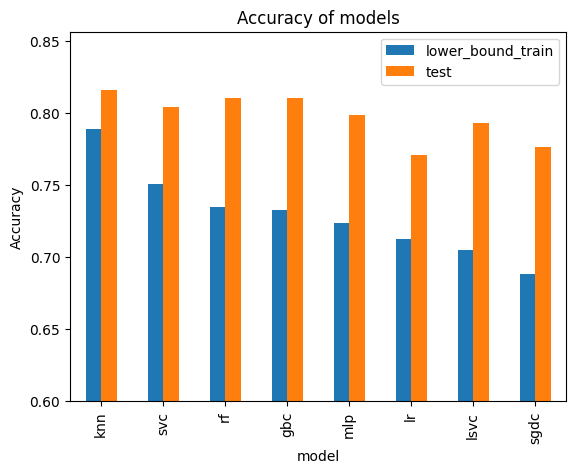

In [36]:
df_score_kfold = pd.DataFrame(score_kfold).sort_values(by = ['lower_bound_train', 'test'], ascending = False)
df_score_kfold.plot(kind = 'bar', x = 'model', y = ['lower_bound_train', 'test'], capsize = 5)
plt.ylim((0.6,None))
plt.ylabel('Accuracy')
plt.title('Accuracy of models');
conclusion = 'KNN is the winner'
print(conclusion)

In [ ]:
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
models = [('mlp', GridSearchCV(make_pipeline(column_trans, mlp), mlp_params, cv = inner_cv, refit = lower_bound)),
            ('sgdc', GridSearchCV(make_pipeline(column_trans, sgdc), sgdc_params, cv = inner_cv, refit = lower_bound)),
            ('lsvc', GridSearchCV(make_pipeline(column_trans, lsvc), lsvc_params, cv = inner_cv, refit = lower_bound)),
            ('svc', GridSearchCV(make_pipeline(column_trans, svc), svc_params, cv = inner_cv, refit = lower_bound)),
            ('knn', GridSearchCV(make_pipeline(column_trans, knn), knn_params, cv = inner_cv, refit = lower_bound)),
            ('gbc', GridSearchCV(make_pipeline(column_trans, gbc), gbc_params, cv = inner_cv, refit = lower_bound)),
            ('lr', GridSearchCV(make_pipeline(column_trans, lr), lr_params, cv = inner_cv, refit = lower_bound)),
            ('rf', GridSearchCV(make_pipeline(column_trans, rf), rf_params, cv = inner_cv, refit = lower_bound))
]
score_kfold_stratify = {'model' : [], 'mean_train': [], 'std_train': [], 'lower_bound_train': [], 'test': []}
scoring = 'accuracy'

for name, model in models:
    nested_cv_results = cross_val_score(model, X_train, y_train, cv=outer_cv, scoring=scoring)
    msg = "Nested CV Accuracy %s: %f (+/- %f )" % (name, nested_cv_results.mean()*100, nested_cv_results.std()*100)
    print(msg)
    model.fit(X_train, y_train)
    print('Test set accuracy: {:.2f}'.format(model.score(X_test, y_test)*100),  '%')
    score_kfold_stratify['model'].append(name)
    score_kfold_stratify['mean_train'].append(nested_cv_results.mean())
    score_kfold_stratify['std_train'].append(nested_cv_results.std())
    score_kfold_stratify['lower_bound_train'].append(nested_cv_results.mean() - 1.96*nested_cv_results.std())
    score_kfold_stratify['test'].append(model.score(X_test, y_test))

GradientBoostingClassifier is the winner


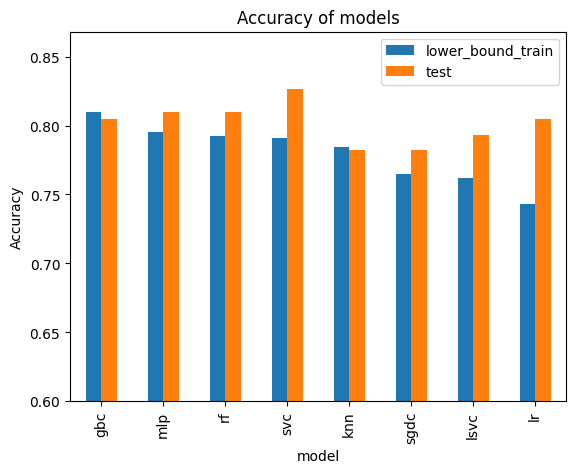

In [32]:
df_score_kfold_stratify = pd.DataFrame(score_kfold_stratify).sort_values(by = ['lower_bound_train', 'test'], ascending = False)
df_score_kfold_stratify.plot(kind = 'bar', x = 'model', y = ['lower_bound_train', 'test'], capsize = 5)
plt.ylim((0.6,None))
plt.ylabel('Accuracy')
plt.title('Accuracy of models');
conclusion = 'GradientBoostingClassifier is the winner'
print(conclusion)

- There are two different winners w.r.t different scenarios
  - When using KFolds cross-validation, the `KNN` is the best estimator. Of course, this condition is more difficult than the StratifiedKFolds
  - When using StratifiedKFolds cross-validation, the `GBC` is the best estimator
  - In the code below, we will continue to expand the searching hyperparameters for both `KNN` and `GBC` w.r.t different cross-validation strategies: `KFolds` and `StratifiedKFolds`

## 3.2 Hyperparameter tuning


- This step, we might use `BayesSearchCV` to find the best hyperparameters, which will save a lot of time when it comes to many hyperparameters
  - Damn, I can not use `BayesSearchCV` if I want to use my defined `refit` function
- In addition, we will also consider OverSampling technique to see if we can enhance the accuracy of the model
- However, `pipeline` not well support for OverSampling technique, therefore, we will need to make a wrapper for our model

### 3.2.1 KNN

In [24]:
class KNNWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors = 5, leaf_size = 30, weights = 'uniform', p = 2, resampling = 'SMOTE'):
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
        self.weights = weights
        self.p = p
        self.resampling = resampling
        self.classes_ = [0, 1]

    def fit(self, X, y):
        model = KNeighborsClassifier(n_neighbors = self.n_neighbors, leaf_size = self.leaf_size, weights = self.weights, p = self.p)
        if self.resampling == 'SMOTE':
            ros = SMOTE(sampling_strategy='auto')
            X, y = ros.fit_resample(X, y)
        elif self.resampling == 'RandomOverSampler':
            ros = RandomOverSampler(sampling_strategy='auto')
            X, y = ros.fit_resample(X, y)
        model.fit(X, y)
        self.model = model
        return self
    
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def score(self, X, y):
        return self.model.score(X, y)

In [26]:
knn_parameters ={
    'knnwrapper__n_neighbors': randint(5, 20),
    'knnwrapper__leaf_size': randint(20, 50),
    'knnwrapper__weights': ['uniform', 'distance'],
    'knnwrapper__p': [1, 2, 3, 4]
}
knn_search_model = RandomizedSearchCV(make_pipeline(column_trans,KNNWrapper(resampling=None)),
                             knn_parameters, 
                             cv=KFold(n_splits=3, shuffle=True, random_state=seed), 
                             verbose = 0, 
                             n_iter = 200, 
                             scoring = 'accuracy',
                             refit = lower_bound)
retrain = True
if retrain:
    np.int = int # This is for the np.int error
    knn_search_model.fit(X, y)
    dump(knn_search_model, 'model/knn_best.joblib')
else:
    knn_search_model = load('model/knn_best.joblib')
print(knn_search_model.best_params_)

{'knnwrapper__leaf_size': 37, 'knnwrapper__n_neighbors': 9, 'knnwrapper__p': 1, 'knnwrapper__weights': 'uniform'}


train accuracy: 0.8439955106621774
              precision    recall  f1-score   support

    Died (0)       0.84      0.92      0.88       549
Survived (1)       0.84      0.73      0.78       342

    accuracy                           0.84       891
   macro avg       0.84      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891



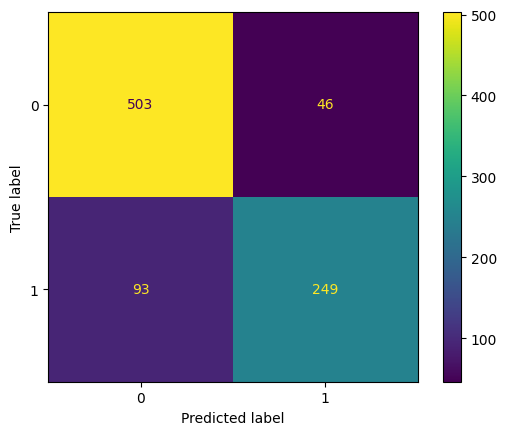

In [27]:
knn_train_accuracy = knn_search_model.score(X, y)
print(f'train accuracy: {knn_train_accuracy}')
y_pred = knn_search_model.predict(X)
print(classification_report(y, y_pred,target_names=['Died (0)', 'Survived (1)']))
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### 3.2.2 GBC

In [38]:
class GBCWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, max_depth = 2,min_samples_split = 0.1,  min_samples_leaf = 0.1,subsample = 1.0, resampling = 'SMOTE'):
        self.n_estimators= n_estimators
        self.max_depth= max_depth
        self.resampling = resampling
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.subsample = subsample
        self.classes_ = [0, 1]

    def fit(self, X, y):
        model = GradientBoostingClassifier(n_estimators=self.n_estimators, max_depth = self.max_depth,min_samples_split = self.min_samples_split,min_samples_leaf =  self.min_samples_leaf, subsample = self.subsample,random_state=42)
        if self.resampling == 'SMOTE':
            ros = SMOTE(sampling_strategy='auto')
            X, y = ros.fit_resample(X, y)
        elif self.resampling == 'RandomOverSampler':
            ros = RandomOverSampler(sampling_strategy='auto')
            X, y = ros.fit_resample(X, y)
        model.fit(X, y)
        self.model = model
        return self
    
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def score(self, X, y):
        return self.model.score(X, y)

In [ ]:
gbc_parameters ={
    'gbcwrapper__n_estimators': randint(25, 500),
    'gbcwrapper__max_depth': randint(2, 30),
    'gbcwrapper__min_samples_split': uniform(0.01, 0.99),
    'gbcwrapper__min_samples_leaf': uniform(0.01, 0.99),
    'gbcwrapper__subsample': uniform(0.01, 0.99)
}
gbc_search_model = RandomizedSearchCV(make_pipeline(column_trans,GBCWrapper(resampling=None)),
                             gbc_parameters, 
                             cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=seed), 
                             verbose = 0, 
                             n_iter = 200, 
                             scoring = 'accuracy',
                             refit = lower_bound)
retrain = False
if retrain:
    np.int = int # This is for the np.int error
    gbc_search_model.fit(X, y)
    dump(gbc_search_model, 'model/gbc_best.joblib')
else:
    gbc_search_model = load('model/gbc_best.joblib')
print(gbc_search_model.best_params_)

train accuracy: 0.8260381593714927
              precision    recall  f1-score   support

    Died (0)       0.84      0.89      0.86       549
Survived (1)       0.81      0.72      0.76       342

    accuracy                           0.83       891
   macro avg       0.82      0.81      0.81       891
weighted avg       0.82      0.83      0.82       891



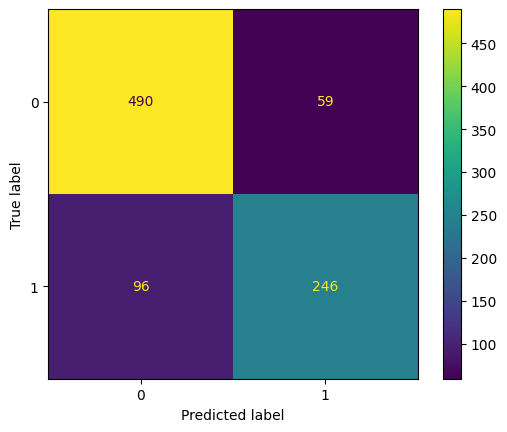

In [59]:
gbc_train_accuracy = gbc_search_model.score(X, y)
print(f'train accuracy: {gbc_train_accuracy}')
y_pred = gbc_search_model.predict(X)
print(classification_report(y, y_pred,target_names=['Died (0)', 'Survived (1)']))
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# 4. Model Evaluation and Interpretation

## 4.1 KNN

In [28]:
test_data = wrangle(path = 'data/test.csv')
test_data = test_data[train_data.columns] # Make sure the columns are in the same order
assert all(test_data.columns == train_data.columns)
X_test = test_data.drop(columns = 'Survived')
y_test = test_data['Survived'] # This is not the real target, just a sample provided by Kaggle
y_knn_test = knn_search_model.predict(X_test)

def prediction_knn(X):
    return knn_search_model.best_estimator_[-1].predict_proba(X)[:,1] # Need to do like this way because shap model does not support pipeline
X_trans = column_trans.fit_transform(X) # Need to do like this way because shap model does not support pipeline
X_test_trans = column_trans.transform(X_test) # Need to do like this way because shap model does not support pipeline
feature_names = knn_search_model.best_estimator_ [0:-1].get_feature_names_out()
explainer = shap.Explainer(prediction_knn, X_trans, feature_names=feature_names 
)
shap_values_knn_train = explainer(X_trans)
shap_values_knn_test = explainer(X_test_trans)

PermutationExplainer explainer: 892it [05:42,  2.53it/s]                         
PermutationExplainer explainer: 419it [02:44,  2.40it/s]                         


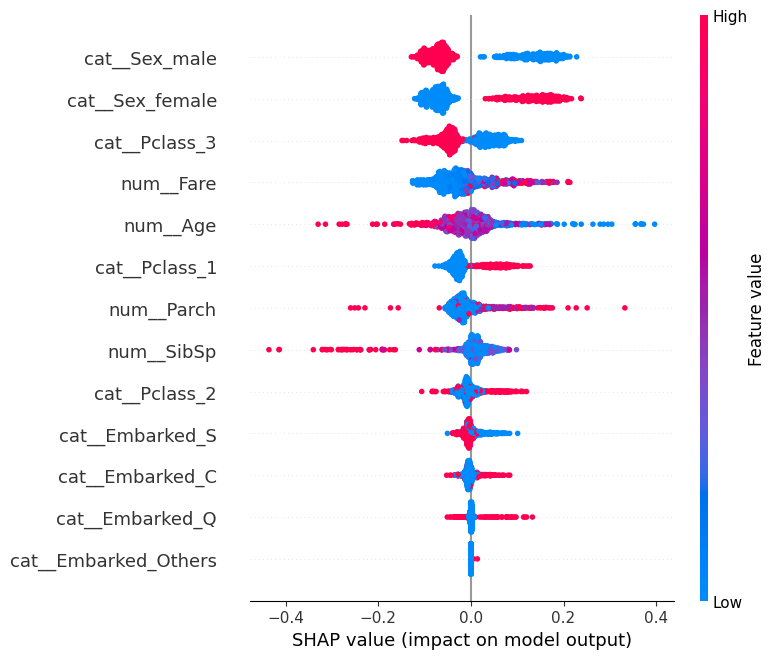

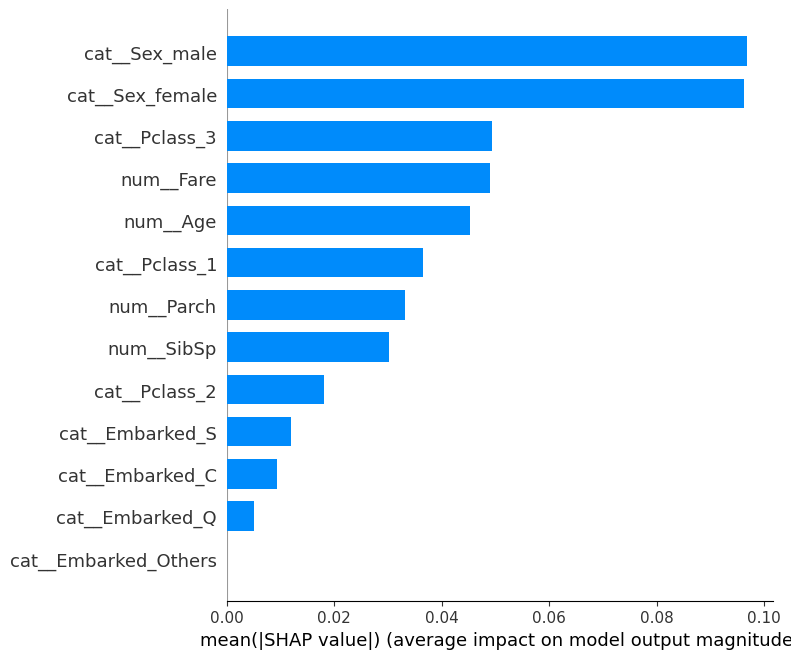

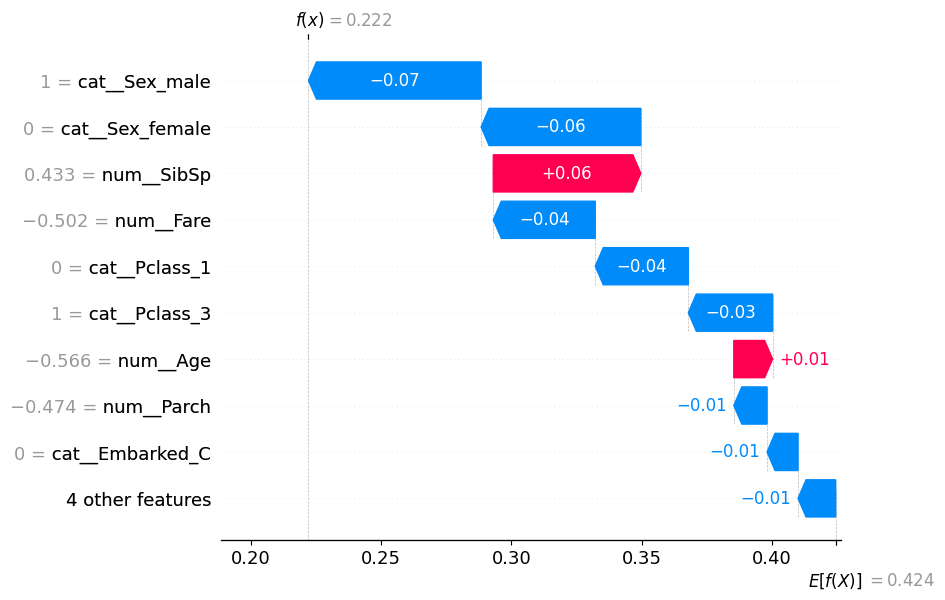

In [29]:
shap.summary_plot(shap_values_knn_train, X_trans, plot_type = 'dot')
shap.summary_plot(shap_values_knn_train, X_trans, plot_type = 'bar')
shap.plots.waterfall(shap_values_knn_train[0])

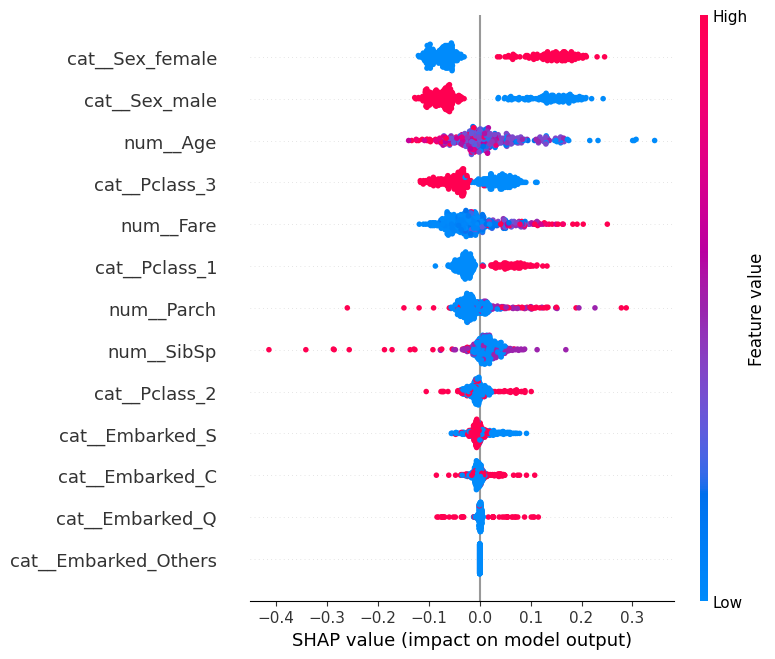

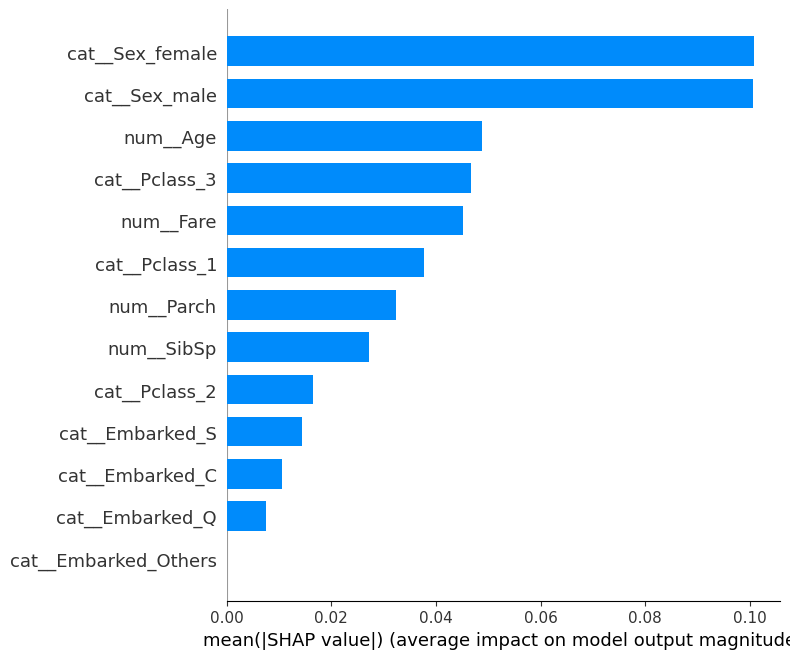

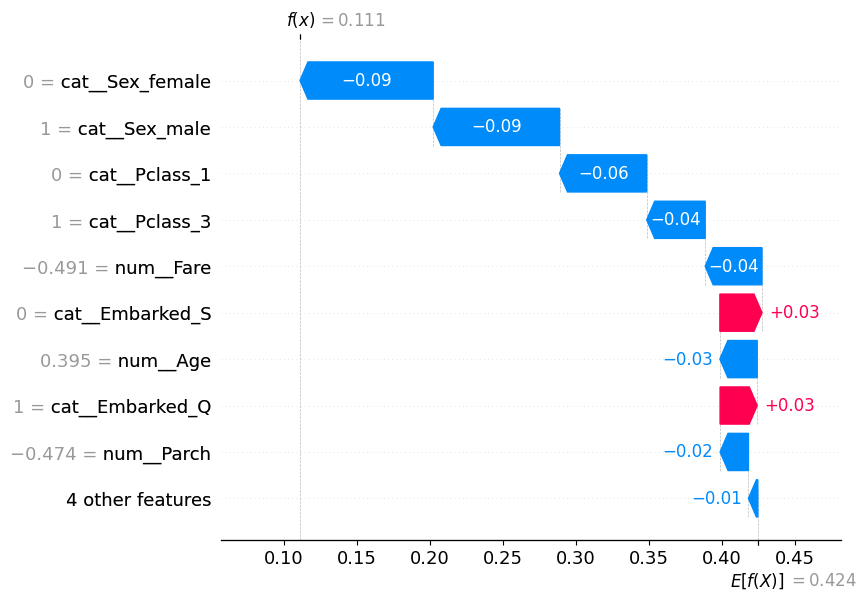

In [30]:
shap.summary_plot(shap_values_knn_test, X_test_trans, plot_type = 'dot')
shap.summary_plot(shap_values_knn_test, X_test_trans, plot_type = 'bar')
shap.plots.waterfall(shap_values_knn_test[0])

## 4.2 GBC

In [63]:
test_data = wrangle(path = 'data/test.csv')
test_data = test_data[train_data.columns] # Make sure the columns are in the same order
assert all(test_data.columns == train_data.columns)
X_test = test_data.drop(columns = 'Survived')
y_test = test_data['Survived'] # This is not the real target, just a sample provided by Kaggle
y_gbc_test = gbc_search_model.predict(X_test)

def prediction_gbc(X):
    return gbc_search_model.best_estimator_[-1].predict_proba(X)[:,1] # Need to do like this way because shap model does not support pipeline
X_trans = column_trans.fit_transform(X) # Need to do like this way because shap model does not support pipeline
X_test_trans = column_trans.transform(X_test) # Need to do like this way because shap model does not support pipeline
feature_names = gbc_search_model.best_estimator_ [0:-1].get_feature_names_out()
explainer = shap.Explainer(prediction_gbc, X_trans, feature_names=feature_names 
)
shap_values_gbc_train = explainer(X_trans)
shap_values_gbc_test = explainer(X_test_trans)

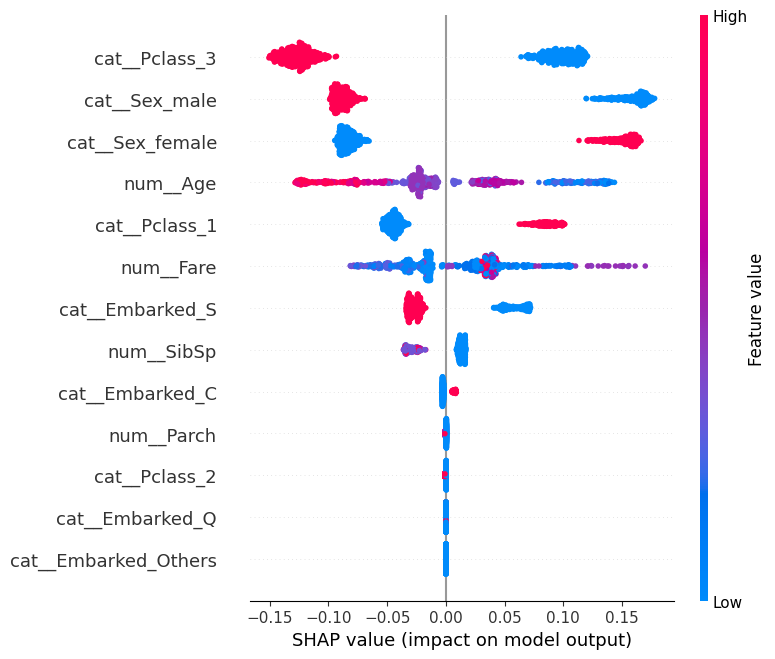

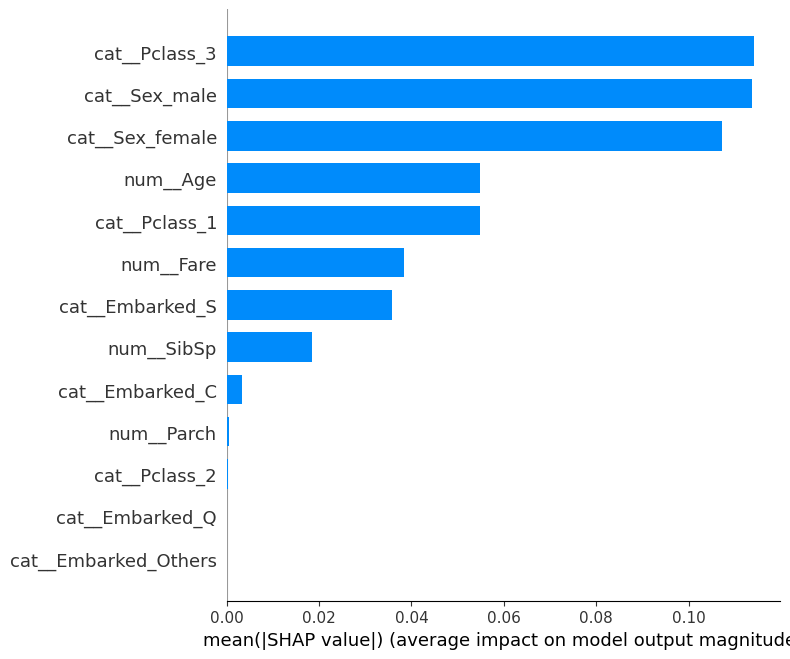

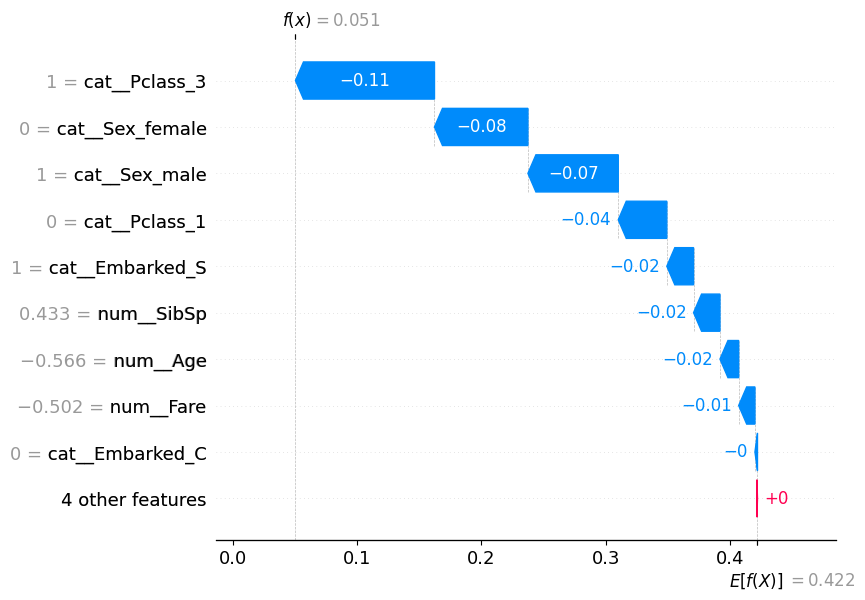

In [62]:
shap.summary_plot(shap_values_gbc_train, X_trans, plot_type = 'dot')
shap.summary_plot(shap_values_gbc_train, X_trans, plot_type = 'bar')
shap.plots.waterfall(shap_values_gbc_train[0])

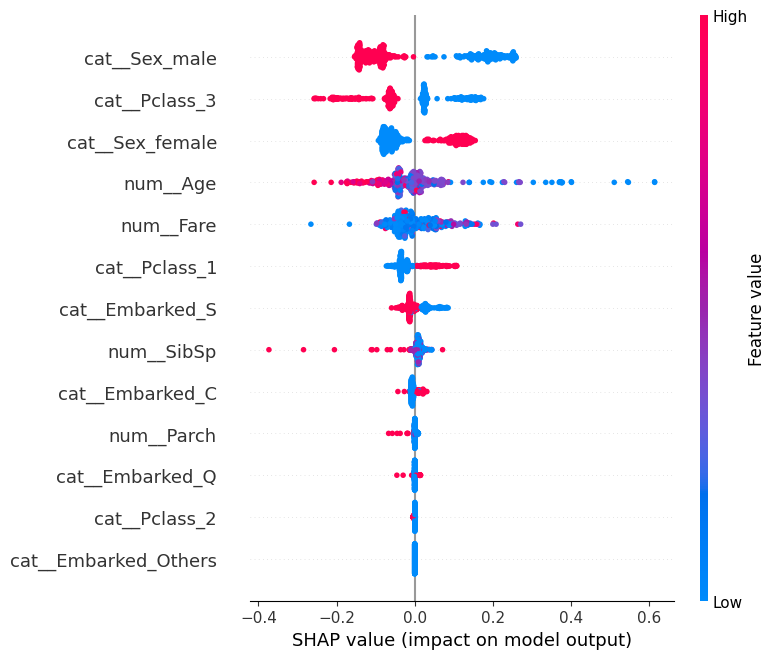

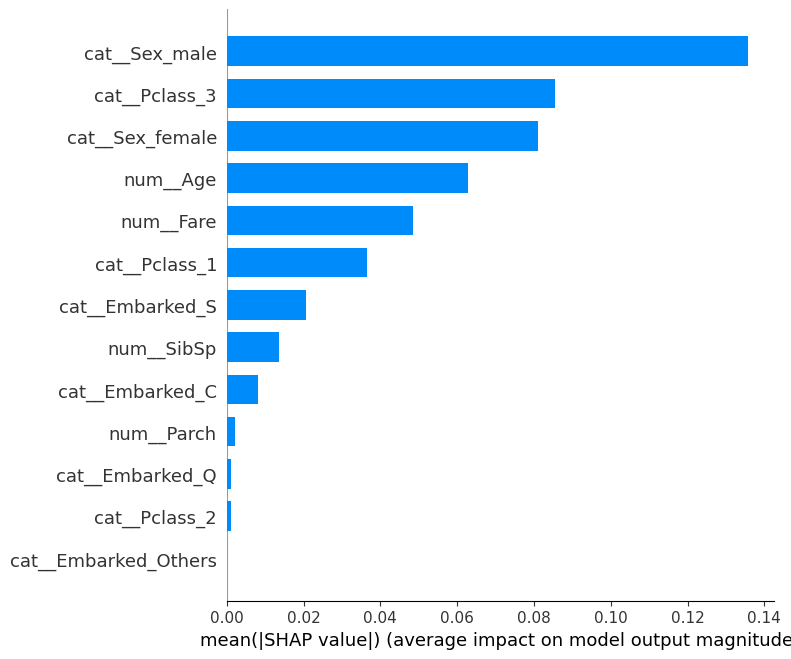

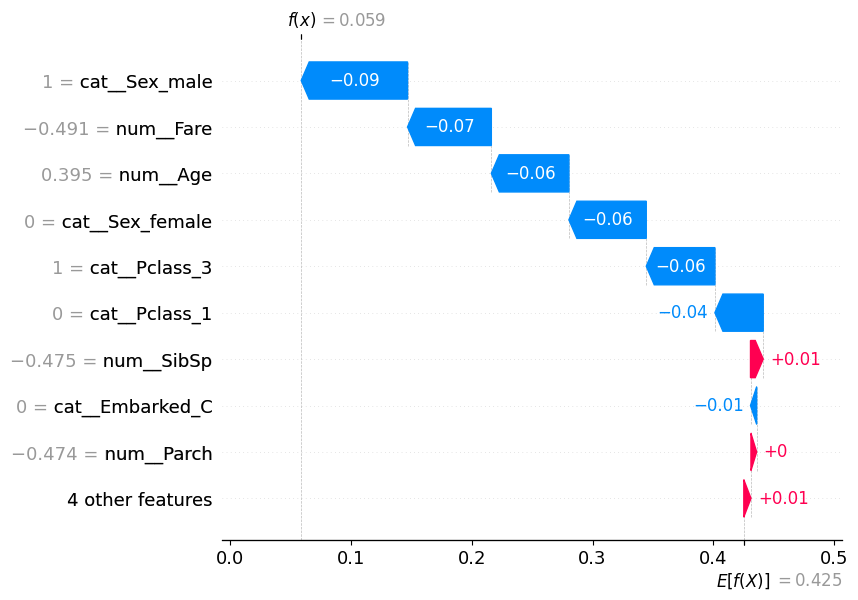

In [28]:
shap.summary_plot(shap_values_gbc_test, X_test_trans, plot_type = 'dot')
shap.summary_plot(shap_values_gbc_test, X_test_trans, plot_type = 'bar')
shap.plots.waterfall(shap_values_gbc_test[0])

- Some conlusions:
  - There about 6 most important features that affect to the output
  - Let's use PCA to reduce the dimension of the transformed data

# 5. Preparation for Kaggle submission

In [32]:
submission = pd.read_csv('data/gender_submission.csv')
submission['Survived'] = y_knn_test.astype(int)
time = pd.Timestamp.now().isoformat(timespec = 'hours')
submission.to_csv('data/KNN_%s.csv' %time, index = False)
print(knn_search_model.best_params_)

{'knnwrapper__leaf_size': 37, 'knnwrapper__n_neighbors': 9, 'knnwrapper__p': 1, 'knnwrapper__weights': 'uniform'}


In [69]:
submission = pd.read_csv('data/gender_submission.csv')
submission['Survived'] = y_gbc_test.astype(int)
time = pd.Timestamp.now().isoformat(timespec = 'minutes')
submission.to_csv('data/GBC_%s.csv' %time, index = False)
print(gbc_search_model.best_params_)

{'gbcwrapper__max_depth': 12, 'gbcwrapper__min_samples_leaf': 0.1054937843150504, 'gbcwrapper__min_samples_split': 0.6851360204416591, 'gbcwrapper__n_estimators': 392, 'gbcwrapper__subsample': 0.7256595419057298}


- Score summary:
  - KNN w/ K-folds: 76.08%
  - GBC w/ stratified K-folds: 76.3%
  - GBC with too much fine tuning: 66.9%
  - GBC without PCA: 77.3%
  - NN With PCA: 77.5%
  - NN Without PCA, with randomOverSampling or SMOTE: 72.3%